# 1. Data load



In [228]:
import pandas as pd
import numpy as np
import random
import os
import matplotlib.pyplot as plt
import seaborn as sn
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
seed_everything()

from sklearn.preprocessing import LabelEncoder,OrdinalEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import seaborn as sns
from sklearn.feature_selection import RFECV

import warnings
warnings.filterwarnings('ignore')

In [229]:
train= pd.read_csv('/content/drive/MyDrive/Dacon/소득 예측/input/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Dacon/소득 예측/input/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/Dacon/소득 예측/input/sample_submission.csv')

In [230]:
train.shape

(20000, 23)

In [231]:
train.head(5)

,ID,Age,Gender,Education_Status,Employment_Status,Working_Week (Yearly),Industry_Status,Occupation_Status,Race,Hispanic_Origin,...,Citizenship,Birth_Country,Birth_Country (Father),Birth_Country (Mother),Tax_Status,Gains,Losses,Dividends,Income_Status,Income
0,TRAIN_00000,63,M,Middle (7-8),Full-Time,4,Social Services,Services,White,All other,...,Native,US,US,US,Nonfiler,0,0,0,Unknown,425
1,TRAIN_00001,37,M,Associates degree (Vocational),Full-Time,52,Entertainment,Services,White,All other,...,Native,US,US,US,Single,0,0,0,Under Median,0
2,TRAIN_00002,58,F,High graduate,Full-Time,52,Manufacturing (Non-durable),Admin Support (include Clerical),Black,All other,...,Native,US,US,US,Married Filling Jointly both under 65 (MFJ),3411,0,0,Under Median,860
3,TRAIN_00003,44,M,High graduate,Full-Time,52,Retail,Technicians & Support,White,All other,...,Native,US,US,US,Single,0,0,0,Under Median,850
4,TRAIN_00004,37,F,High graduate,Full-Time,52,Retail,Sales,White,All other,...,Native,US,US,US,Head of Household (HOH),0,0,0,Unknown,570


In [232]:
# 범주형 17개, 연속형 6개
train.dtypes.value_counts()

object    17
int64      6
dtype: int64

# 2. EDA

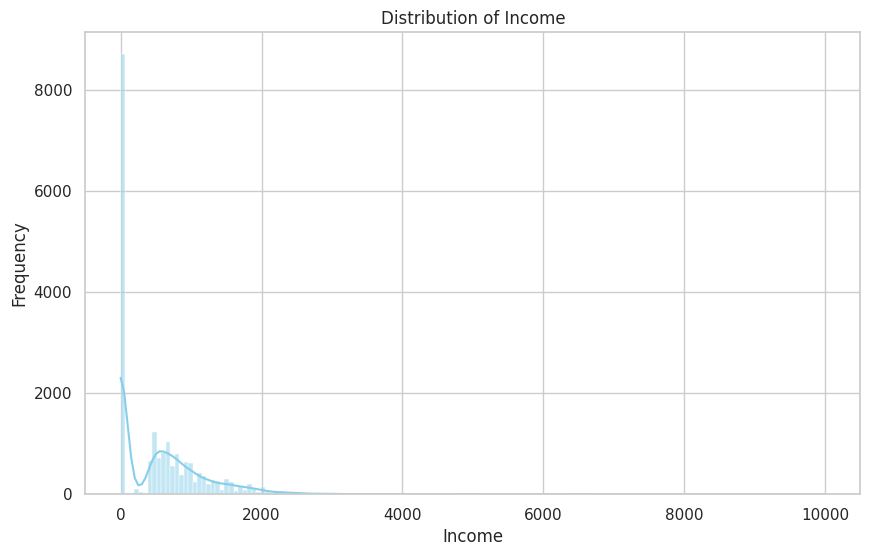

In [233]:
#1. 타겟 변수인 소득의 분포 확인 : 40%가 무소득
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(train['Income'], kde=True, color='skyblue')
plt.title('Distribution of Income')
plt.xlabel('Income')
plt.ylabel('Frequency')
plt.show()

남자 평균 소득 :  623.6203820319059
여자 평균 소득 :  491.73510313216195


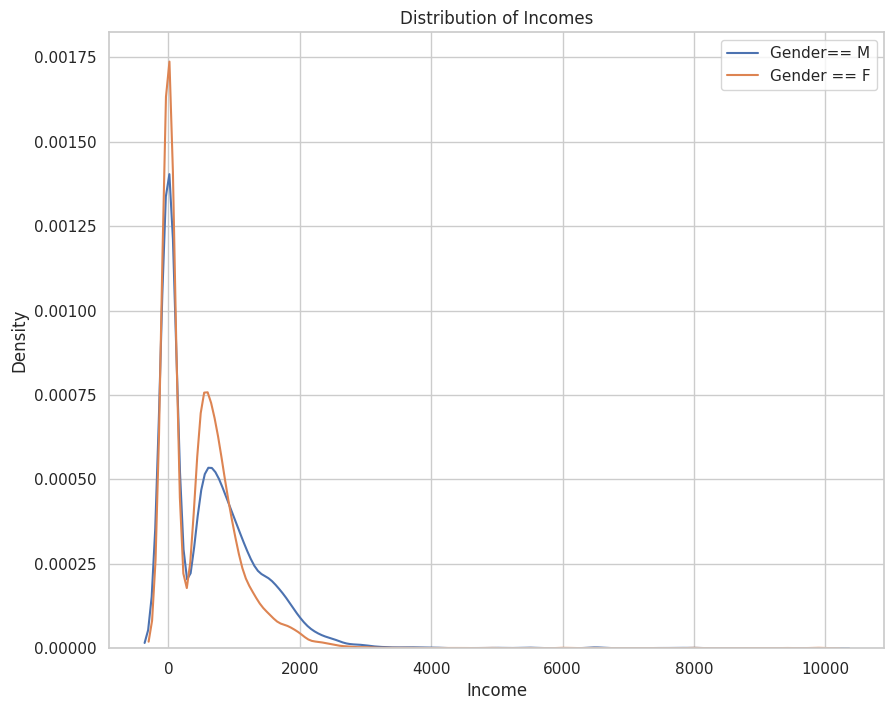

In [234]:
#2. 성별에 따른 소득 : 남자가 여자보다 평균 소득 높음, 여자가 무소득인 비율이 더 많다.
plt.figure(figsize = (10, 8))
sns.kdeplot(train.loc[train['Gender'] == 'M', 'Income'], label = 'Gender== M')
sns.kdeplot(train.loc[train['Gender'] == 'F', 'Income'], label = 'Gender == F')
plt.xlabel('Income'); plt.ylabel('Density'); plt.title('Distribution of Incomes')
plt.legend()
print("남자 평균 소득 : " ,train[train['Gender'] == 'M']['Income'].mean())
print("여자 평균 소득 : " ,train[train['Gender'] == 'F']['Income'].mean())

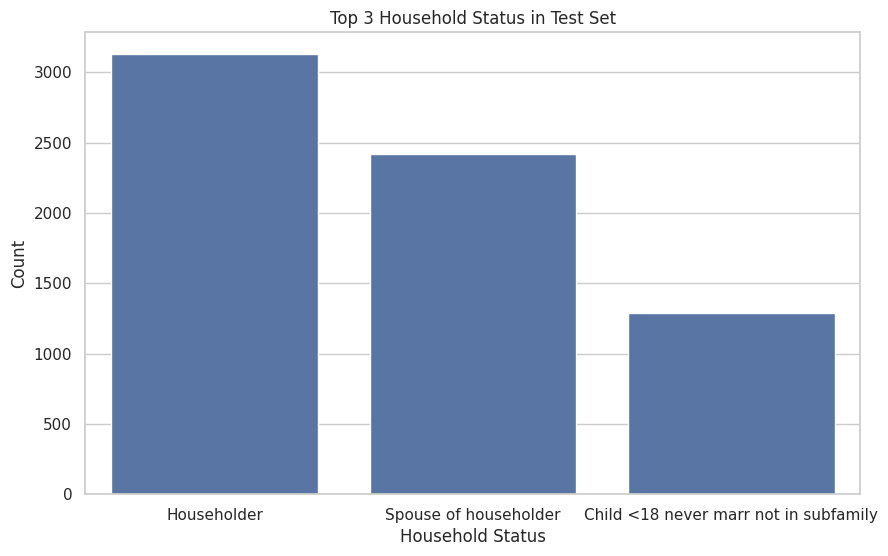

In [235]:
#3. Household_Status의 분포 확인 -> Household 제일 많음
household_status_counts = test['Household_Status'].value_counts().head(3)
plt.figure(figsize=(10, 6))
sns.countplot(data=test, x='Household_Status', order=household_status_counts.index)
plt.title('Top 3 Household Status in Test Set')
plt.xlabel('Household Status')
plt.ylabel('Count')
plt.show()
test['Household_Status'].fillna('Householder', inplace=True)


Average Income for White individuals: 563.5542297417632
Average Income for Black individuals: 512.7309142318568
Average Income for Asian/Pacific individuals: 524.5127201565558
Average Income for Other individuals: 411.2060810810811
Average Income for Native American/Aleut/Eskimo individuals: 533.0796460176991
Ratio of White individuals with zero income: 0.4302760463045414
Ratio of Black individuals with zero income: 0.4344957587181904
Ratio of Asian/Pacific individuals with zero income: 0.4892367906066536
Ratio of Other individuals with zero income: 0.581081081081081
Ratio of Native American/Aleut/Eskimo individuals with zero income: 0.4646017699115044


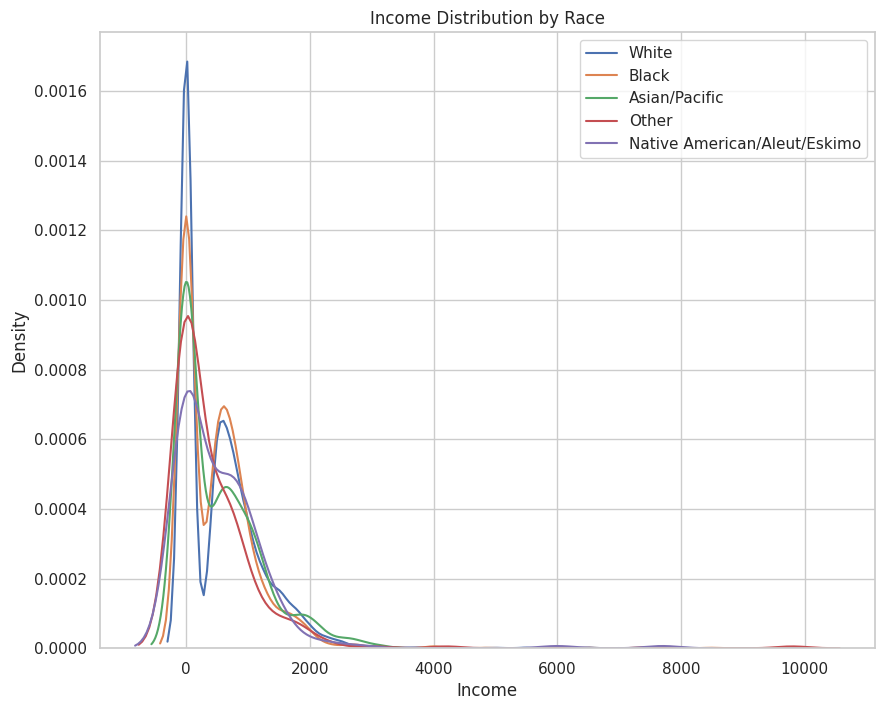

In [236]:
#4. 인종에 따른 소득 확인
plt.figure(figsize=(10, 8))
sns.kdeplot(train.loc[train['Race'] == 'White', 'Income'], label='White')
sns.kdeplot(train.loc[train['Race'] == 'Black', 'Income'], label='Black')
sns.kdeplot(train.loc[train['Race'] == 'Asian/Pacific', 'Income'], label='Asian/Pacific')
sns.kdeplot(train.loc[train['Race'] == 'Other', 'Income'], label='Other')
sns.kdeplot(train.loc[train['Race'] == 'Native American/Aleut/Eskimo', 'Income'], label='Native American/Aleut/Eskimo')
plt.xlabel('Income')
plt.ylabel('Density')
plt.title('Income Distribution by Race')
plt.legend()

white_mean_income = train[train['Race'] == 'White']['Income'].mean()
black_mean_income = train[train['Race'] == 'Black']['Income'].mean()
asian_mean_income = train[train['Race'] == 'Asian/Pacific']['Income'].mean()
other_mean_income = train[train['Race'] == 'Other']['Income'].mean()
native_mean_income = train[train['Race'] == 'Native American/Aleut/Eskimo']['Income'].mean()

print("Average Income for White individuals:", white_mean_income)
print("Average Income for Black individuals:", black_mean_income)
print("Average Income for Asian/Pacific individuals:", asian_mean_income)
print("Average Income for Other individuals:", other_mean_income)
print("Average Income for Native American/Aleut/Eskimo individuals:", native_mean_income)

white_zero_income_ratio = (train[train['Race'] == 'White']['Income'] == 0).mean()
black_zero_income_ratio = (train[train['Race'] == 'Black']['Income'] == 0).mean()
asian_zero_income_ratio = (train[train['Race'] == 'Asian/Pacific']['Income'] == 0).mean()
other_zero_income_ratio = (train[train['Race'] == 'Other']['Income'] == 0).mean()
native_zero_income_ratio = (train[train['Race'] == 'Native American/Aleut/Eskimo']['Income'] == 0).mean()

print("Ratio of White individuals with zero income:", white_zero_income_ratio)
print("Ratio of Black individuals with zero income:", black_zero_income_ratio)
print("Ratio of Asian/Pacific individuals with zero income:", asian_zero_income_ratio)
print("Ratio of Other individuals with zero income:", other_zero_income_ratio)
print("Ratio of Native American/Aleut/Eskimo individuals with zero income:", native_zero_income_ratio)

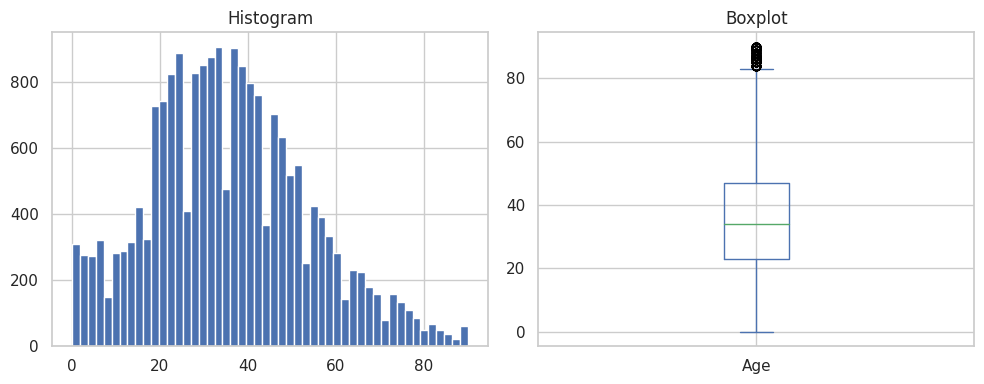

In [237]:
#5. 나이 분포 확인
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
train['Age'].hist(bins =  50,ax=axes[0])
axes[0].set_title('Histogram')
train['Age'].plot(kind = 'box',ax=axes[1])
axes[1].set_title('Boxplot')
plt.tight_layout()
plt.show()

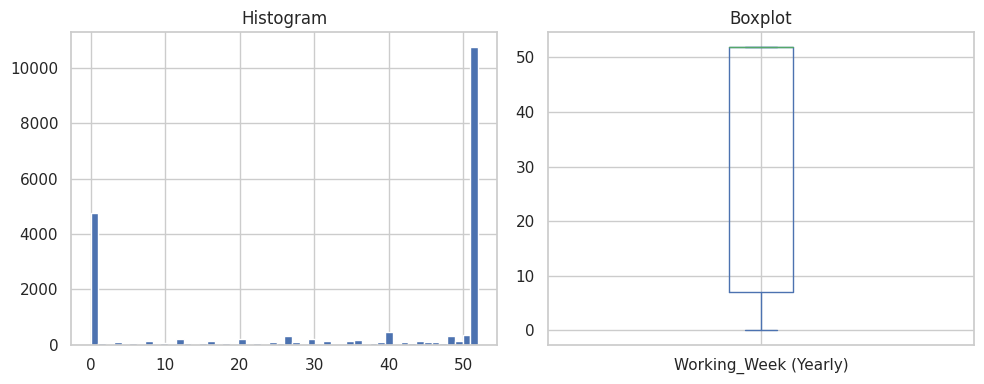

In [238]:
#6. Working_Week 시각화
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

train['Working_Week (Yearly)'].hist(bins =  50,ax=axes[0])
axes[0].set_title('Histogram')

train['Working_Week (Yearly)'].plot(kind = 'box',ax=axes[1])
axes[1].set_title('Boxplot')

plt.tight_layout()

# Show the plot
plt.show()

Average Income for Working 52 Weeks: 771.8571563177236
Average Income for Not Working: 39.85953389830509


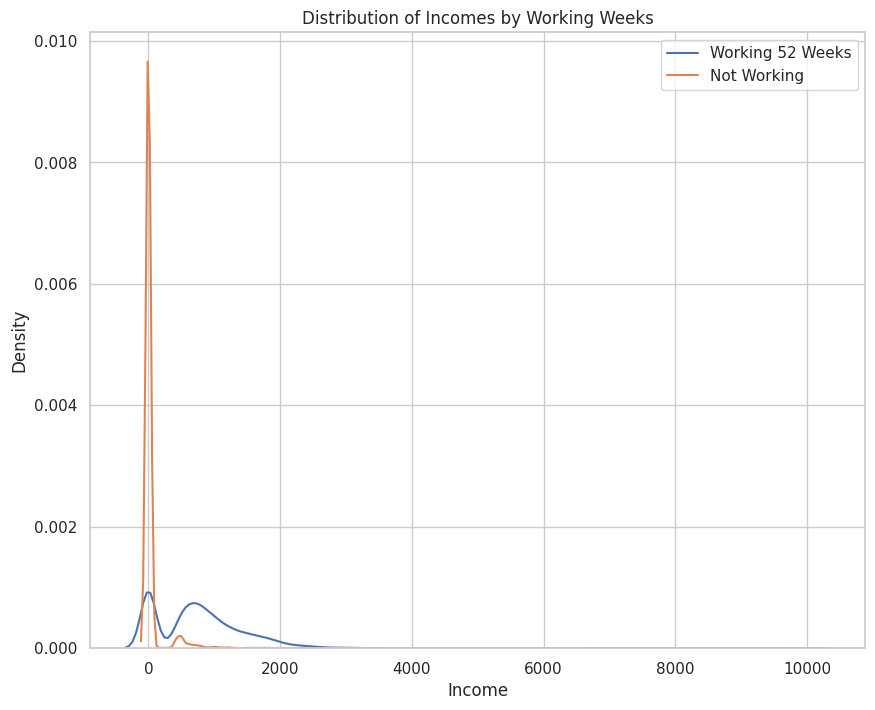

In [239]:
#7. Working_Week (Yearly) 가 0주이면 소득도 0일 확률이 높다
plt.figure(figsize=(10, 8))
sns.kdeplot(train.loc[train['Working_Week (Yearly)'] == 52, 'Income'], label='Working 52 Weeks')
sns.kdeplot(train.loc[train['Working_Week (Yearly)'] == 0, 'Income'], label='Not Working')
plt.xlabel('Income')
plt.ylabel('Density')
plt.title('Distribution of Incomes by Working Weeks')
plt.legend()
mean_income_working = train[train['Working_Week (Yearly)'] == 52]['Income'].mean()
mean_income_not_working = train[train['Working_Week (Yearly)'] == 0]['Income'].mean()
print("Average Income for Working 52 Weeks:", mean_income_working)
print("Average Income for Not Working:", mean_income_not_working)


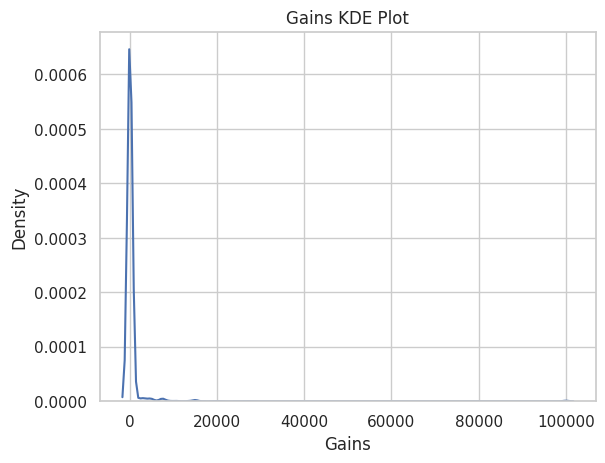

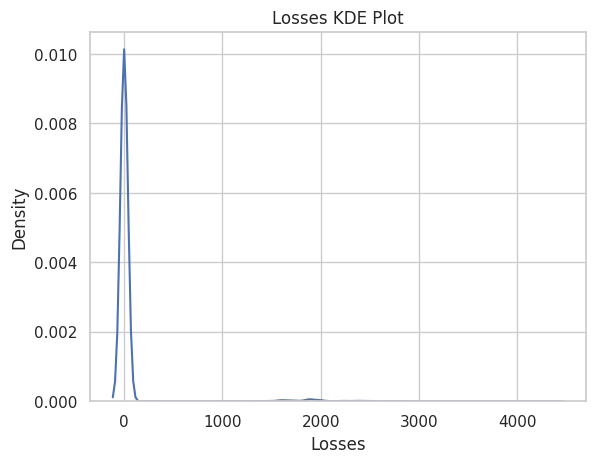

In [240]:
#8. Gains와 Losses 시각화
sns.kdeplot(data=train['Gains'])
plt.title('Gains KDE Plot')
plt.xlabel('Gains')
plt.show()
sns.kdeplot(data=train['Losses'])
plt.title('Losses KDE Plot')
plt.xlabel('Losses')
plt.show()

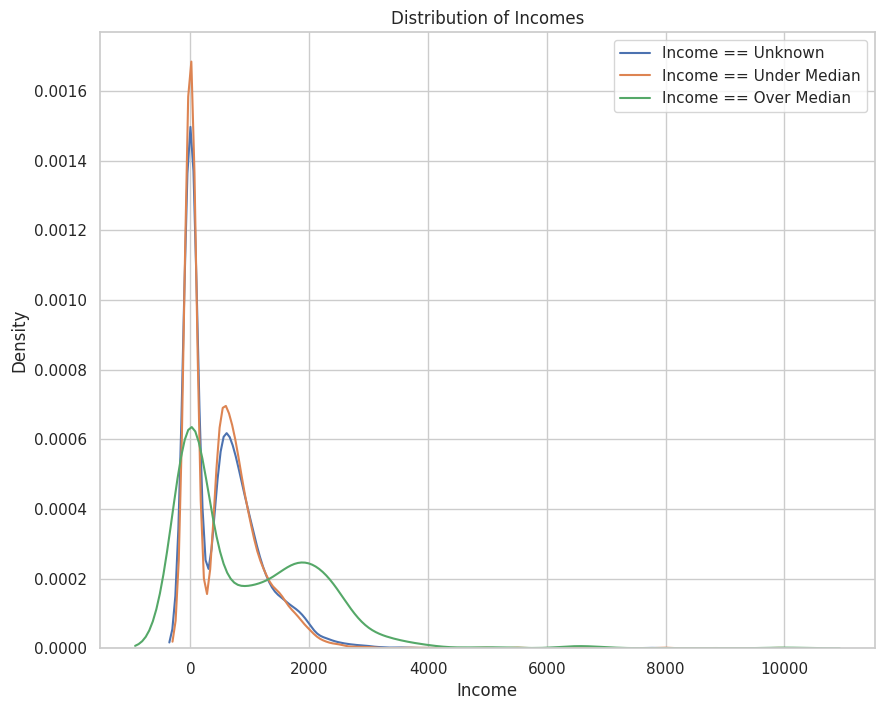

In [241]:
#9. 소득 상태에 따른 시각화
plt.figure(figsize=(10, 8))
sns.kdeplot(train.loc[train['Income_Status'] == 'Unknown', 'Income'], label='Income == Unknown')
sns.kdeplot(train.loc[train['Income_Status'] == 'Under Median', 'Income'], label='Income == Under Median')
sns.kdeplot(train.loc[train['Income_Status'] == 'Over Median', 'Income'], label='Income == Over Median')
plt.xlabel('Income')
plt.ylabel('Density')
plt.title('Distribution of Incomes')
plt.legend()
plt.show()
train.loc[(train['Income_Status']  == 'Unknown'), 'Income_Status'] = 'Under Median'
test.loc[(test['Income_Status']  == 'Unknown'), 'Income_Status'] = 'Under Median'

In [242]:
#10. 결측치를 최빈값으로 대체
train.loc[(train['Birth_Country']  == 'Unknown'), 'Birth_Country'] = 'US'
train.loc[(train['Birth_Country (Mother)']  == 'Unknown'), 'Birth_Country (Mother)'] = 'US'
train.loc[(train['Birth_Country (Father)']  == 'Unknown'), 'Birth_Country (Father)'] = 'US'
train.loc[(train['Hispanic_Origin'] == ' Do not know') | (train['Hispanic_Origin'] == ' NA'), 'Hispanic_Origin'] = 'All other'
test.loc[(test['Birth_Country'] == 'Unknown'), 'Income_Status'] = 'US'
test.loc[(test['Birth_Country (Mother)'] == 'Unknown'), 'Birth_Country (Mother)'] = 'US'
test.loc[(test['Birth_Country (Father)'] == 'Unknown'), 'Birth_Country (Father)'] = 'US'
test.loc[(test['Hispanic_Origin'] == ' Do not know') | (test['Hispanic_Origin'] == ' NA'), 'Hispanic_Origin'] = 'All other'


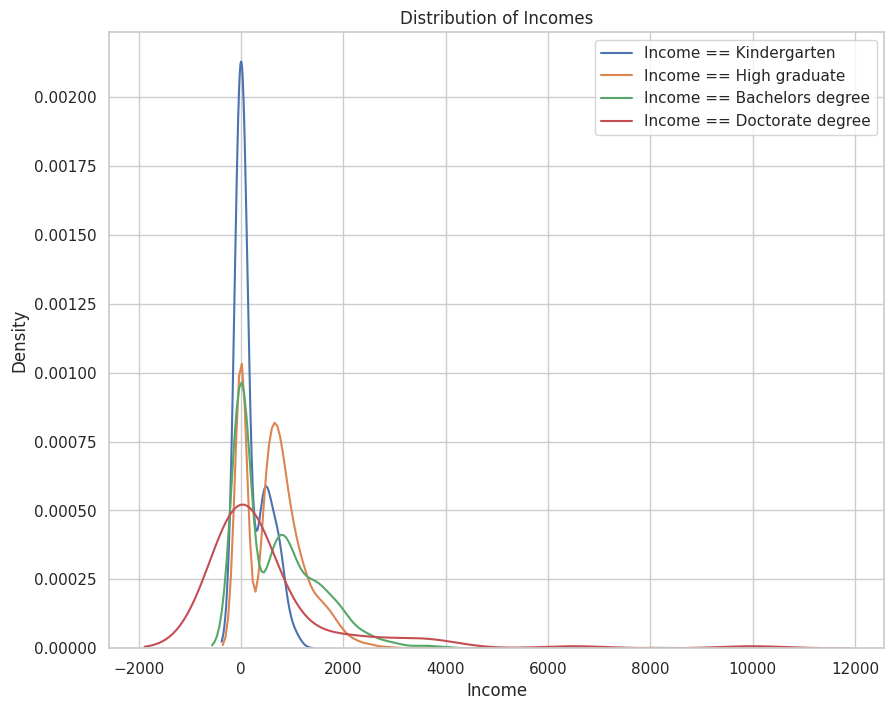

In [243]:
#11. 교육 상태에 따른 시각화
plt.figure(figsize=(10, 8))
sns.kdeplot(train.loc[train['Education_Status'] == 'Kindergarten', 'Income'], label='Income == Kindergarten')
sns.kdeplot(train.loc[train['Education_Status'] == 'High graduate', 'Income'], label='Income == High graduate')
sns.kdeplot(train.loc[train['Education_Status'] == 'Bachelors degree', 'Income'], label='Income == Bachelors degree')
sns.kdeplot(train.loc[train['Education_Status'] == 'Doctorate degree', 'Income'], label='Income == Doctorate degree')
plt.xlabel('Income')
plt.ylabel('Density')
plt.title('Distribution of Incomes')
plt.legend()
plt.show()

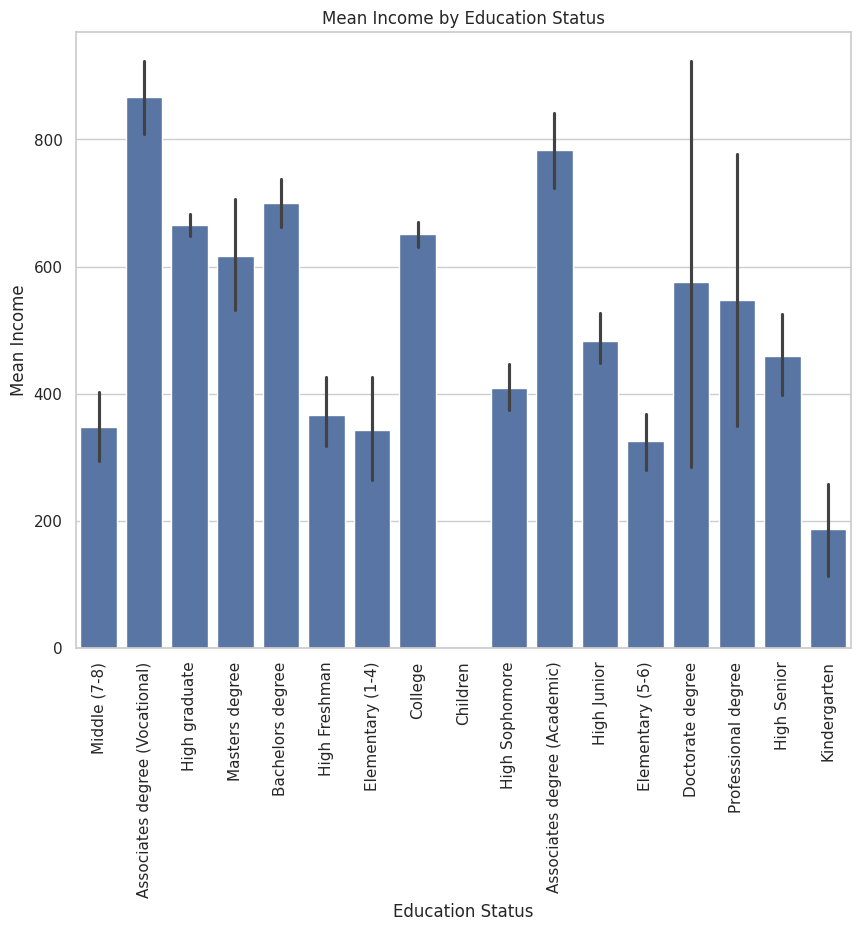

In [244]:
#12. 교육 상태에 따른 평균 소득 barplot
plt.figure(figsize=(10, 8))
sns.barplot(data=train, x='Education_Status', y='Income')
plt.xlabel('Education Status')
plt.ylabel('Mean Income')
plt.title('Mean Income by Education Status')
plt.xticks(rotation=90)
plt.show()


# 3. Encoding

In [246]:
#1. Education_Status, Gender 라벨 인코딩
education_mapping = {
    'Kindergarten': 0,
    'Children': 1,
    'Elementary (1-4)': 2,
    'Elementary (5-6)': 3,
    'Middle (7-8)': 4,
    'High Freshman': 5,
    'High Sophomore': 6,
    'High Junior': 7,
    'High Senior': 8,
    'High graduate' : 9,
    'College': 10,
    'Associates degree (Vocational)': 11,
    'Associates degree (Academic)': 12,
    'Bachelors degree': 13,
    'Masters degree': 14,
    'Doctorate degree': 15,
    'Professional degree': 16,
}


# Gender 매핑 딕셔너리
gender_mapping = {
    'M': 0,
    'F': 1,
}

# 매핑 적용
train['Education_Status'] = train['Education_Status'].map(education_mapping)
test['Education_Status'] = test['Education_Status'].map(education_mapping)

train['Gender'] = train['Gender'].map(gender_mapping)
test['Gender'] = test['Gender'].map(gender_mapping)

In [247]:
#2. 원핫 인코딩 후 inner join 수행
train = pd.get_dummies(train,dtype='int64')

test = pd.get_dummies(test,dtype='int64')

print('Training Features shape: ', train.shape)
print('Testing Features shape: ', test.shape)

train_labels = train['Income']

# Align the training and testing data, keep only columns present in both dataframes
train, test = train.align(test, join = 'inner', axis = 1)

# Add the target back in
train['TARGET'] = train_labels


print('Training Features shape: ', train.shape)
print('Testing Features shape: ', test.shape)

Training Features shape:  (20000, 20254)
Testing Features shape:  (10000, 10249)
Training Features shape:  (20000, 248)
Testing Features shape:  (10000, 247)


#4. Feature Engineering

In [248]:
#1. 파생 변수 생성
train['No_Working_Week'] = train['Working_Week (Yearly)'] == 0
train['Earnings'] =train['Gains'] - train['Losses']
train['No_Earnings'] = train['Earnings'] == 0
test['No_Working_Week'] = test['Working_Week (Yearly)'] == 0
test['Earnings'] = test['Gains'] - test['Losses']
test['No_Earnings'] = test['Earnings'] == 0

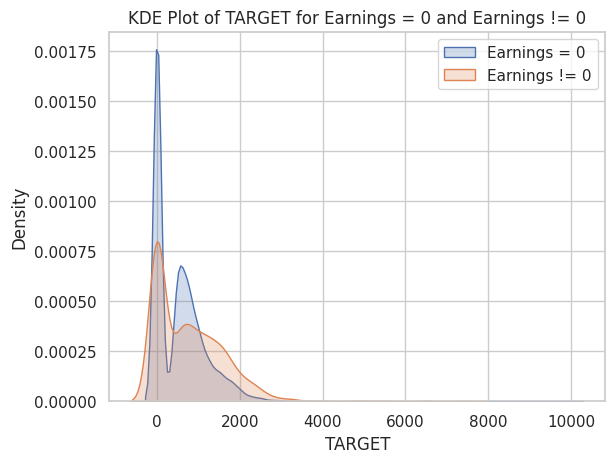

In [249]:
#2 순이익에 따른 소득
earnings_zero_target = train.loc[train['Earnings'] == 0]['TARGET']
earnings_nonzero_target = train.loc[train['Earnings'] != 0]['TARGET']
sns.kdeplot(earnings_zero_target, shade=True, label='Earnings = 0')
sns.kdeplot(earnings_nonzero_target, shade=True, label='Earnings != 0')
plt.xlabel('TARGET')
plt.ylabel('Density')
plt.title('KDE Plot of TARGET for Earnings = 0 and Earnings != 0')
plt.legend()
plt.show()


In [250]:
#3. 정규화
from sklearn.preprocessing import StandardScaler
X_train = train[['Gains', 'Losses', 'Dividends','Earnings']]  # 특성으로 사용할 칼럼 선택
X_test = test[['Gains', 'Losses', 'Dividends','Earnings']]
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)
X_train_normalized_df = pd.DataFrame(X_train_normalized, columns=['Gains_normalized', 'Losses_normalized', 'Dividends_normalized','Earnings_normalized'], index=train.index)
X_test_normalized_df = pd.DataFrame(X_test_normalized, columns=['Gains_normalized', 'Losses_normalized', 'Dividends_normalized','Earnings_normalized'], index=test.index)
train = pd.concat([train, X_train_normalized_df], axis=1)
test = pd.concat([test, X_test_normalized_df], axis=1)
train.drop(columns=['Gains', 'Losses', 'Dividends','Earnings'], inplace=True)
test.drop(columns=['Gains', 'Losses', 'Dividends','Earnings'], inplace=True)

In [251]:
#4. 상관계수 확인
correlation_matrix = train.corr()
target_correlation = correlation_matrix['TARGET']
sorted_correlation = target_correlation.sort_values(ascending=False)
top_positive_correlation = sorted_correlation[sorted_correlation > 0].head(10)
top_negative_correlation = sorted_correlation[sorted_correlation < 0].tail(10)
print("Top 10 positive correlations:")
print(top_positive_correlation)
print("\nTop 10 negative correlations:")
print(top_negative_correlation)


Top 10 positive correlations:
TARGET                                                    1.000000
Working_Week (Yearly)                                     0.419628
Education_Status                                          0.292230
Tax_Status_Married Filling Jointly both under 65 (MFJ)    0.232359
Occupation_Status_Craft & Repair                          0.197641
Employment_Status_Full-Time                               0.192177
Martial_Status_Married                                    0.180813
Household_Summary_Householder                             0.177718
Household_Status_Householder                              0.163832
Industry_Status_Manufacturing (Durable)                   0.147053
Name: TARGET, dtype: float64

Top 10 negative correlations:
Employment_Status_Children or Armed Forces               -0.106054
Income_Status_Under Median                               -0.107769
Employment_Status_Not Working                            -0.201569
Martial_Status_Single                  

In [252]:
#5. train셋 나누기
from sklearn.metrics import mean_squared_error
X = train.drop(columns=['TARGET'])
y = train['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.columns = [col.replace('[', '').replace(']', '').replace('<', '') for col in X_train.columns]
X_test.columns = [col.replace('[', '').replace(']', '').replace('<', '') for col in X_test.columns]

#5. Modeling

In [254]:
#1. K-fold 교차 검증
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

lgb_model = lgb.LGBMRegressor()

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores = []
for train_index, test_index in kfold.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    lgb_model.fit(X_train_fold, y_train_fold)

    lgb_val_predictions = lgb_model.predict(X_val_fold)

    val_rmse = np.sqrt(mean_squared_error(y_val_fold, lgb_val_predictions))
    rmse_scores.append(val_rmse)

print("Mean RMSE:", np.mean(rmse_scores))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 948
[LightGBM] [Info] Number of data points in the train set: 12800, number of used features: 175
[LightGBM] [Info] Start training from score 555.713984
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006460 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 961
[LightGBM] [Info] Number of data points in the train set: 12800, number of used features: 180
[LightGBM] [Info] Start training from score 556.405234
[LightGBM] [Warning] Fou

In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.8 MB/s eta 0:00:00


In [ ]:
#2. optuna로 하이퍼파라미터 최적화
import optuna
def objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_scores = []
    for train_index, test_index in kfold.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        model = lgb.LGBMRegressor(**params)
        model.fit(X_train_fold, y_train_fold)

        val_predictions = model.predict(X_val_fold)
        rmse = np.sqrt(mean_squared_error(y_val_fold, val_predictions))
        rmse_scores.append(rmse)

    return np.mean(rmse_scores)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


[I 2024-03-17 05:58:22,011] A new study created in memory with name: no-name-179c805e-2436-4087-8e16-62f008bcdb2c
[I 2024-03-17 05:58:27,115] Trial 0 finished with value: 598.648509335035 and parameters: {'lambda_l1': 0.003317009291900801, 'lambda_l2': 0.0006014354542076103, 'num_leaves': 162, 'feature_fraction': 0.7456915185715818, 'bagging_fraction': 0.96858821747966, 'bagging_freq': 7, 'min_child_samples': 92}. Best is trial 0 with value: 598.648509335035.
[I 2024-03-17 05:58:29,905] Trial 1 finished with value: 597.6961636220788 and parameters: {'lambda_l1': 9.819069100448362e-07, 'lambda_l2': 0.010950919411220552, 'num_leaves': 47, 'feature_fraction': 0.4932361031086678, 'bagging_fraction': 0.933087331353062, 'bagging_freq': 5, 'min_child_samples': 15}. Best is trial 1 with value: 597.6961636220788.
[I 2024-03-17 05:58:31,803] Trial 2 finished with value: 596.113091081886 and parameters: {'lambda_l1': 2.207672089017095, 'lambda_l2': 3.1575647619937395e-05, 'num_leaves': 21, 'featu

Best trial:
  Value: 590.1373130750915
  Params: 
    lambda_l1: 2.987881493082484e-08
    lambda_l2: 0.166552364908269
    num_leaves: 9
    feature_fraction: 0.5413458915432082
    bagging_fraction: 0.8980936670096786
    bagging_freq: 3
    min_child_samples: 43


In [255]:
#3. 최적의 파라미터로 예측 수행
best_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'lambda_l1': 2.987881493082484e-08,
    'lambda_l2': 0.166552364908269,
    'num_leaves': 9,
    'feature_fraction': 0.5413458915432082,
    'bagging_fraction': 0.8980936670096786,
    'bagging_freq': 3,
    'min_child_samples': 43,
}
best_lgb_model = lgb.LGBMRegressor(**best_params)
best_lgb_model.fit(X_train, y_train)
lgb_predictions = best_lgb_model.predict(X_test)
lgb_rmse = np.sqrt(mean_squared_error(y_test, lgb_predictions))
print("Final LightGBM Regression RMSE:", lgb_rmse)
#Final LightGBM Regression RMSE: 587.7955148082875

Final LightGBM Regression RMSE: 587.9256954629436


In [257]:
#4. 제출
test.columns = [col.replace('[', '').replace(']', '').replace('<', '') for col in X_test.columns]
submission['Income'] =best_lgb_model.predict(test)
submission.to_csv('INCOME_PREDICT.csv', index = False)